In [ ]:
# Just calling library, for package part of assigment
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
#Networ from scratch without using any library
input_size = 784  # 28x28
h1_size = 500
h2_size = 250
h3_size = 100
output_size = 10
learning_rate = 0.01
batch_size = 64
epochs = 15
alpha = 0.001 #regularization hyperparameter

# Data Loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize Weights and Biases with Glorot Initialization
def glorot_init(in_size, out_size):
    limit = np.sqrt(6 / (in_size + out_size))
    return np.random.uniform(-limit, limit, (in_size, out_size))

In [ ]:
def one_hot_numpy(labels, num_classes):
    # Create an array of zeros with shape (number of labels, number of classes)
    one_hot = np.zeros((labels.shape[0], num_classes))

    # Set the appropriate index to 1 for each label
    one_hot[np.arange(labels.shape[0]), labels] = 1

    return one_hot

In [ ]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, activation):
        # Weights Initialization
        self.W1 = glorot_init(input_size, h1_size)
        self.b1 = np.zeros((1, h1_size))
        self.W2 = glorot_init(h1_size, h2_size)
        self.b2 = np.zeros((1, h2_size))
        self.W3 = glorot_init(h2_size, h3_size)
        self.b3 = np.zeros((1, h3_size))
        self.W4 = glorot_init(h3_size, output_size)
        self.b4 = np.zeros((1, output_size))

        # Activation Function
        self.activation = activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def tanh(self, z):
        return np.tanh(z)

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, x):
        # Forward Pass
        self.z1 = np.dot(x, self.W1) + self.b1
        if self.activation == 'sigmoid':
            self.a1 = self.sigmoid(self.z1)
        elif self.activation == 'tanh':
            self.a1 = self.tanh(self.z1)
        elif self.activation == 'relu':
            self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        if self.activation == 'sigmoid':
            self.a2 = self.sigmoid(self.z2)
        elif self.activation == 'tanh':
            self.a2 = self.tanh(self.z2)
        elif self.activation == 'relu':
            self.a2 = self.relu(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        if self.activation == 'sigmoid':
            self.a3 = self.sigmoid(self.z3)
        elif self.activation == 'tanh':
            self.a3 = self.tanh(self.z3)
        elif self.activation == 'relu':
            self.a3 = self.relu(self.z3)

        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.output = self.softmax(self.z4)

        return self.output

    def backward(self, x, y, output):
        m = y.shape[0]

        # Output Layer Gradients
        dz4 = output - y
        dW4 = np.dot(self.a3.T, dz4) / m
        db4 = np.sum(dz4, axis=0, keepdims=True) / m

        # Hidden Layer 3 Gradients
        if self.activation == 'sigmoid':
            dz3 = np.dot(dz4, self.W4.T) * self.a3 * (1 - self.a3)
        elif self.activation == 'tanh':
            dz3 = np.dot(dz4, self.W4.T) * (1 - self.a3 ** 2)
        elif self.activation == 'relu':
            dz3 = np.dot(dz4, self.W4.T) * (self.a3 > 0)

        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # Hidden Layer 2 Gradients
        if self.activation == 'sigmoid':
            dz2 = np.dot(dz3, self.W3.T) * self.a2 * (1 - self.a2)
        elif self.activation == 'tanh':
            dz2 = np.dot(dz3, self.W3.T) * (1 - self.a2 ** 2)
        elif self.activation == 'relu':
            dz2 = np.dot(dz3, self.W3.T) * (self.a2 > 0)

        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden Layer 1 Gradients
        if self.activation == 'sigmoid':
            dz1 = np.dot(dz2, self.W2.T) * self.a1 * (1 - self.a1)
        elif self.activation == 'tanh':
            dz1 = np.dot(dz2, self.W2.T) * (1 - self.a1 ** 2)
        elif self.activation == 'relu':
            dz1 = np.dot(dz2, self.W2.T) * (self.a1 > 0)

        dW1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W4 -= learning_rate * dW4
        self.b4 -= learning_rate * db4
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, train_loader):
        all_losses = []
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                # Flatten the input image (28x28) to a 1D vector of size 784
                x = data.view(-1, input_size).numpy()

                # Convert target labels to one-hot encoding using numpy
                y = one_hot_numpy(target.numpy(), num_classes=output_size)

                # Forward pass
                output = self.forward(x)

                # Backward pass
                self.backward(x, y, output)

                # Log the loss every 200 iterations
                if batch_idx % 200 == 0:
                    loss = -np.sum(y * np.log(output + 1e-8)) / y.shape[0]  # Cross entropy loss
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss:.4f}')
                    all_losses.append(loss)

        return all_losses

    def evaluate(self, data_loader, typ):
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        for data, target in data_loader:
            x = data.view(-1, input_size).numpy()
            target = target.numpy()
            output = self.forward(x)
            preds = np.argmax(output, axis=1)
            all_preds.extend(preds)
            all_labels.extend(target)
            correct += np.sum(preds == target)
            total += target.shape[0]

        accuracy = correct / total
        print(f'{typ} Accuracy: {accuracy * 100:.2f}%')

        cm = confusion_matrix(all_labels, all_preds)
        print(classification_report(all_labels, all_preds))

        # Plotting Confusion Matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[i for i in range(10)], yticklabels=[i for i in range(10)])
        plt.title(f'{typ} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


In [ ]:
# Initialize and train the network with sigmoid activation
nns = NeuralNetwork(activation='sigmoid')

In [ ]:
train_losses_s = nns.train(train_loader)


Epoch 1/15, Batch 0/938, Loss: 2.5042
Epoch 1/15, Batch 200/938, Loss: 2.2978
Epoch 1/15, Batch 400/938, Loss: 2.3071
Epoch 1/15, Batch 600/938, Loss: 2.2781
Epoch 1/15, Batch 800/938, Loss: 2.2668
Epoch 2/15, Batch 0/938, Loss: 2.2785
Epoch 2/15, Batch 200/938, Loss: 2.2535
Epoch 2/15, Batch 400/938, Loss: 2.2533
Epoch 2/15, Batch 600/938, Loss: 2.2295
Epoch 2/15, Batch 800/938, Loss: 2.2083
Epoch 3/15, Batch 0/938, Loss: 2.1863
Epoch 3/15, Batch 200/938, Loss: 2.1848
Epoch 3/15, Batch 400/938, Loss: 2.1120
Epoch 3/15, Batch 600/938, Loss: 2.1146
Epoch 3/15, Batch 800/938, Loss: 2.0408
Epoch 4/15, Batch 0/938, Loss: 1.9873
Epoch 4/15, Batch 200/938, Loss: 1.8903
Epoch 4/15, Batch 400/938, Loss: 1.9060
Epoch 4/15, Batch 600/938, Loss: 1.7651
Epoch 4/15, Batch 800/938, Loss: 1.7219
Epoch 5/15, Batch 0/938, Loss: 1.6506
Epoch 5/15, Batch 200/938, Loss: 1.5623
Epoch 5/15, Batch 400/938, Loss: 1.4749
Epoch 5/15, Batch 600/938, Loss: 1.2312
Epoch 5/15, Batch 800/938, Loss: 1.2584
Epoch 6/15

Train Accuracy: 88.44%
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5923
           1       0.92      0.96      0.94      6742
           2       0.87      0.86      0.87      5958
           3       0.87      0.85      0.86      6131
           4       0.90      0.87      0.88      5842
           5       0.84      0.80      0.82      5421
           6       0.90      0.93      0.92      5918
           7       0.90      0.90      0.90      6265
           8       0.86      0.84      0.85      5851
           9       0.84      0.84      0.84      5949

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



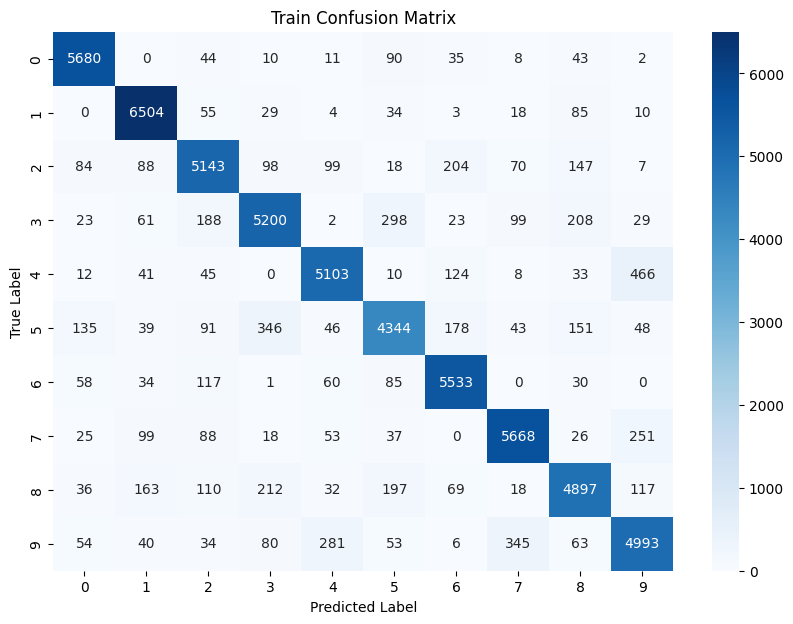

In [ ]:
nns.evaluate(train_loader, 'Train')  # Train accuaracy and CM for sigmoid activation

Test Accuracy: 88.92%
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.94      0.97      0.96      1135
           2       0.89      0.87      0.88      1032
           3       0.87      0.89      0.88      1010
           4       0.88      0.89      0.89       982
           5       0.85      0.78      0.81       892
           6       0.90      0.92      0.91       958
           7       0.91      0.90      0.91      1028
           8       0.86      0.84      0.85       974
           9       0.86      0.84      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



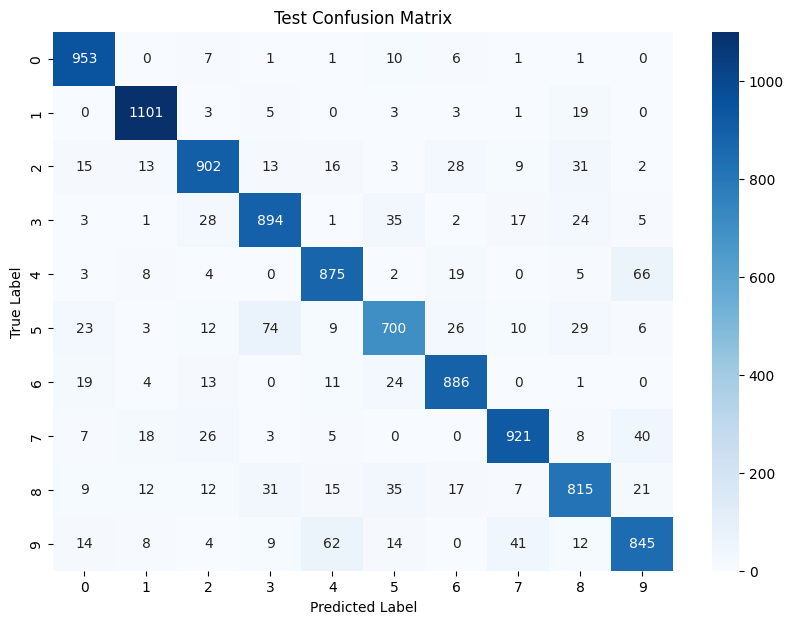

In [ ]:
nns.evaluate(test_loader, 'Test')  # Test accuaracy and CM for sigmoid activation

In [ ]:
plt.plot(train_losses_s)
plt.title('Training Loss Every 200 Iterations')
plt.xlabel('Batch Iteration (x200)')
plt.ylabel('Loss')
plt.show()


In [ ]:
nnt = NeuralNetwork(activation='tanh')

In [ ]:
train_losses_t = nnt.train(train_loader)

Epoch 1/15, Batch 0/938, Loss: 2.5010
Epoch 1/15, Batch 200/938, Loss: 0.4800
Epoch 1/15, Batch 400/938, Loss: 0.4113
Epoch 1/15, Batch 600/938, Loss: 0.4421
Epoch 1/15, Batch 800/938, Loss: 0.3865
Epoch 2/15, Batch 0/938, Loss: 0.3153
Epoch 2/15, Batch 200/938, Loss: 0.1762
Epoch 2/15, Batch 400/938, Loss: 0.2699
Epoch 2/15, Batch 600/938, Loss: 0.2856
Epoch 2/15, Batch 800/938, Loss: 0.3712
Epoch 3/15, Batch 0/938, Loss: 0.2640
Epoch 3/15, Batch 200/938, Loss: 0.2228
Epoch 3/15, Batch 400/938, Loss: 0.2424
Epoch 3/15, Batch 600/938, Loss: 0.2157
Epoch 3/15, Batch 800/938, Loss: 0.2799
Epoch 4/15, Batch 0/938, Loss: 0.1635
Epoch 4/15, Batch 200/938, Loss: 0.2271
Epoch 4/15, Batch 400/938, Loss: 0.2709
Epoch 4/15, Batch 600/938, Loss: 0.2952
Epoch 4/15, Batch 800/938, Loss: 0.1988
Epoch 5/15, Batch 0/938, Loss: 0.2712
Epoch 5/15, Batch 200/938, Loss: 0.2299
Epoch 5/15, Batch 400/938, Loss: 0.1228
Epoch 5/15, Batch 600/938, Loss: 0.1452
Epoch 5/15, Batch 800/938, Loss: 0.1865
Epoch 6/15

Train Accuracy: 98.04%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.99      0.98      0.98      5958
           3       0.98      0.97      0.98      6131
           4       0.95      0.99      0.97      5842
           5       0.98      0.98      0.98      5421
           6       0.98      0.99      0.99      5918
           7       0.98      0.98      0.98      6265
           8       0.98      0.97      0.98      5851
           9       0.98      0.97      0.97      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



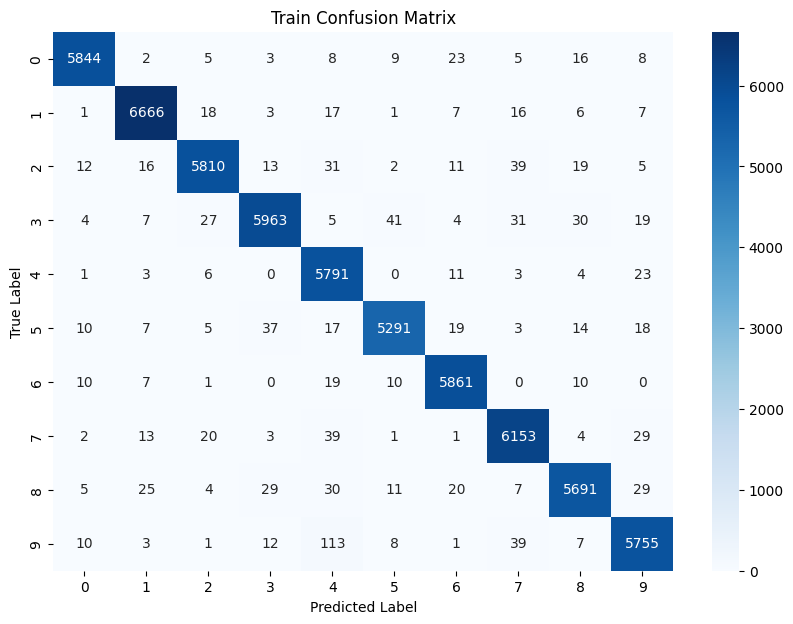

In [ ]:
nnt.evaluate(train_loader, 'Train')  # Train accuaracy and CM for tanh activation

Test Accuracy: 97.14%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.95      0.98      0.97       982
           5       0.97      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



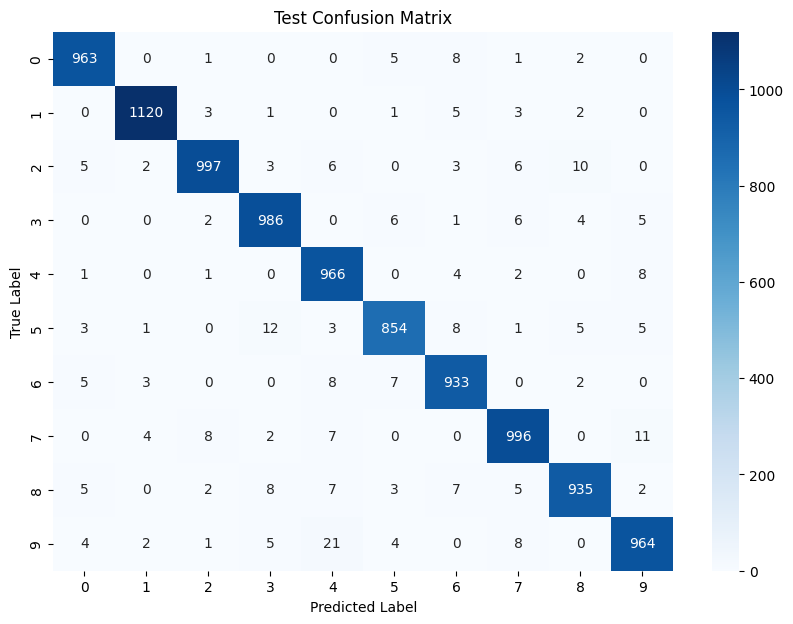

In [ ]:
nnt.evaluate(test_loader, 'Test')  # Test accuaracy and CM for tanh activation
#

In [ ]:
plt.plot(train_losses_t)
plt.title('Training Loss Every 200 Iterations')
plt.xlabel('Batch Iteration (x200)')
plt.ylabel('Loss')
plt.show()


In [ ]:
nnr = NeuralNetwork(activation='relu')

In [ ]:
train_losses_r = nnr.train(train_loader)

Epoch 1/15, Batch 0/938, Loss: 2.2664
Epoch 1/15, Batch 200/938, Loss: 0.7667
Epoch 1/15, Batch 400/938, Loss: 0.5114
Epoch 1/15, Batch 600/938, Loss: 0.4191
Epoch 1/15, Batch 800/938, Loss: 0.3678
Epoch 2/15, Batch 0/938, Loss: 0.4172
Epoch 2/15, Batch 200/938, Loss: 0.2868
Epoch 2/15, Batch 400/938, Loss: 0.2901
Epoch 2/15, Batch 600/938, Loss: 0.2385
Epoch 2/15, Batch 800/938, Loss: 0.3166
Epoch 3/15, Batch 0/938, Loss: 0.2722
Epoch 3/15, Batch 200/938, Loss: 0.0743
Epoch 3/15, Batch 400/938, Loss: 0.3606
Epoch 3/15, Batch 600/938, Loss: 0.1951
Epoch 3/15, Batch 800/938, Loss: 0.1571
Epoch 4/15, Batch 0/938, Loss: 0.2064
Epoch 4/15, Batch 200/938, Loss: 0.1130
Epoch 4/15, Batch 400/938, Loss: 0.1687
Epoch 4/15, Batch 600/938, Loss: 0.0835
Epoch 4/15, Batch 800/938, Loss: 0.1012
Epoch 5/15, Batch 0/938, Loss: 0.2872
Epoch 5/15, Batch 200/938, Loss: 0.2511
Epoch 5/15, Batch 400/938, Loss: 0.1231
Epoch 5/15, Batch 600/938, Loss: 0.1146
Epoch 5/15, Batch 800/938, Loss: 0.0557
Epoch 6/15

Train Accuracy: 98.43%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.98      0.99      0.99      6742
           2       0.99      0.97      0.98      5958
           3       0.97      0.99      0.98      6131
           4       0.98      0.98      0.98      5842
           5       0.99      0.98      0.98      5421
           6       0.99      0.99      0.99      5918
           7       0.99      0.98      0.99      6265
           8       0.99      0.97      0.98      5851
           9       0.97      0.99      0.98      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



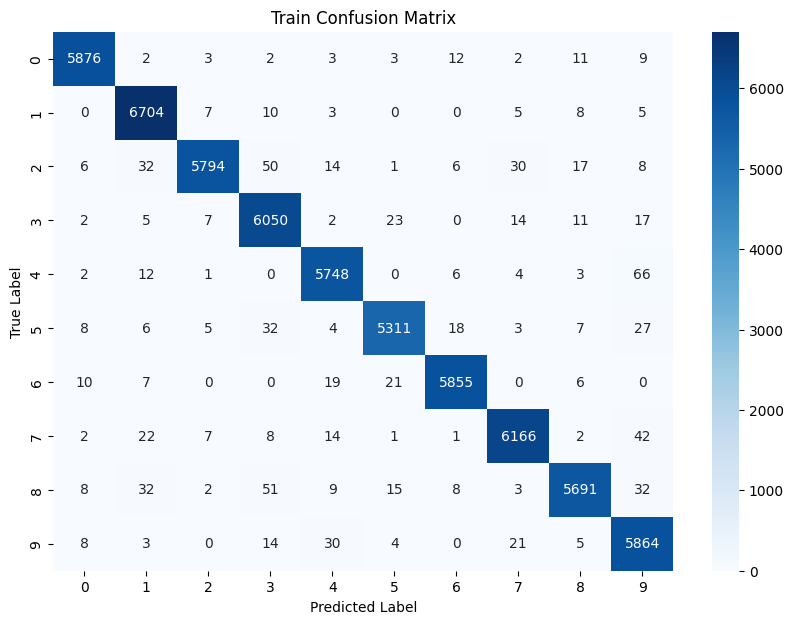

In [ ]:
nnr.evaluate(train_loader, 'Train')  # Train accuaracy and CM for relu activation

Test Accuracy: 97.02%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.95      0.97      1032
           3       0.94      0.98      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



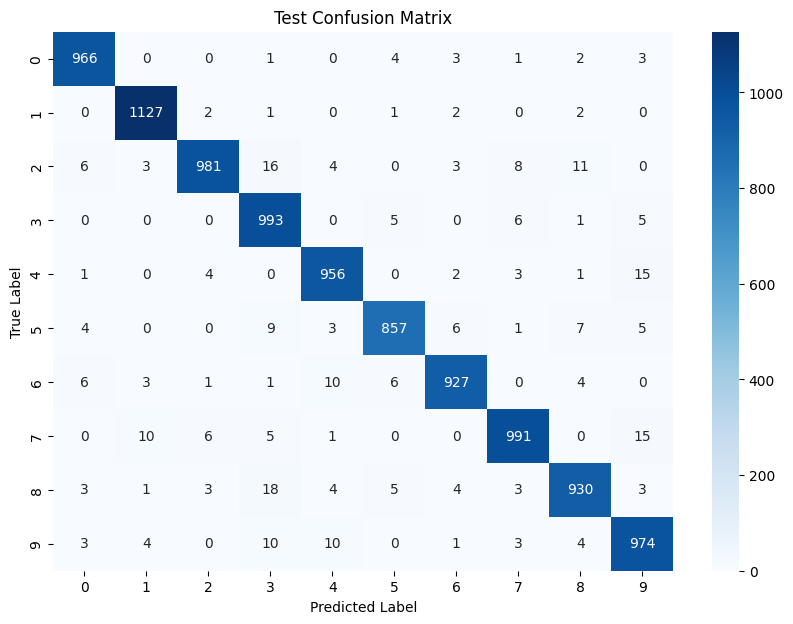

In [ ]:
nnr.evaluate(test_loader, 'Test')  # Test accuaracy and CM for relu activation
#

In [ ]:
plt.plot(train_losses_r)
plt.title('Training Loss Every 200 Iterations')
plt.xlabel('Batch Iteration (x200)')
plt.ylabel('Loss')
plt.show()



from above results, the loss is minimum for relu activation function and overall accuracy is high for relu than any other activation, hence relu activation is best and thus resulting model is the best model

Epoch [1/15], Loss: 0.4610
Epoch [2/15], Loss: 0.3229
Epoch [3/15], Loss: 0.3181
Epoch [4/15], Loss: 0.2999
Epoch [5/15], Loss: 0.2919
Epoch [6/15], Loss: 0.2876
Epoch [7/15], Loss: 0.2902
Epoch [8/15], Loss: 0.2886
Epoch [9/15], Loss: 0.2936
Epoch [10/15], Loss: 0.2840
Epoch [11/15], Loss: 0.2850
Epoch [12/15], Loss: 0.2827
Epoch [13/15], Loss: 0.2789
Epoch [14/15], Loss: 0.2819
Epoch [15/15], Loss: 0.2880
Test Accuracy: 93.18%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.99      0.95      0.97      1135
           2       0.93      0.95      0.94      1032
           3       0.96      0.88      0.92      1010
           4       0.91      0.95      0.93       982
           5       0.93      0.90      0.92       892
           6       0.94      0.96      0.95       958
           7       0.96      0.89      0.92      1028
           8       0.87      0.95      0.91       974
           9       0.87   

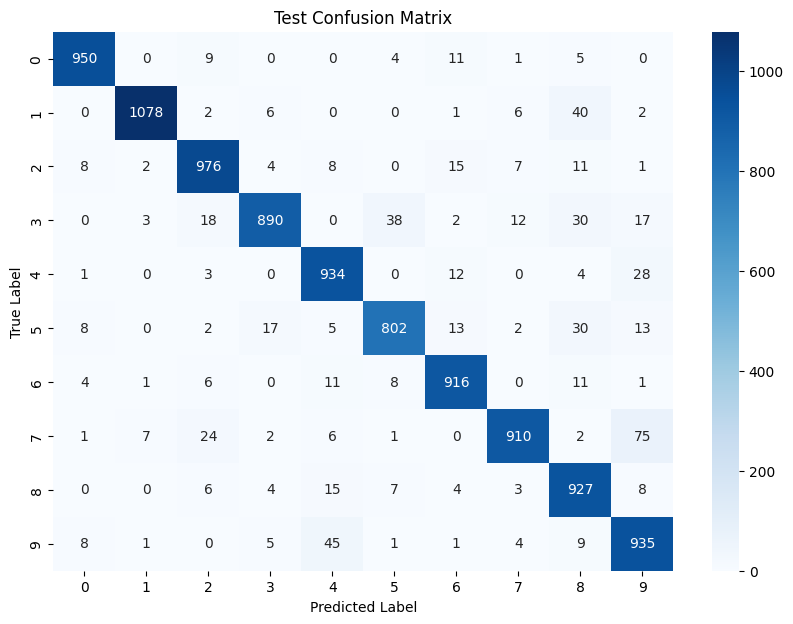

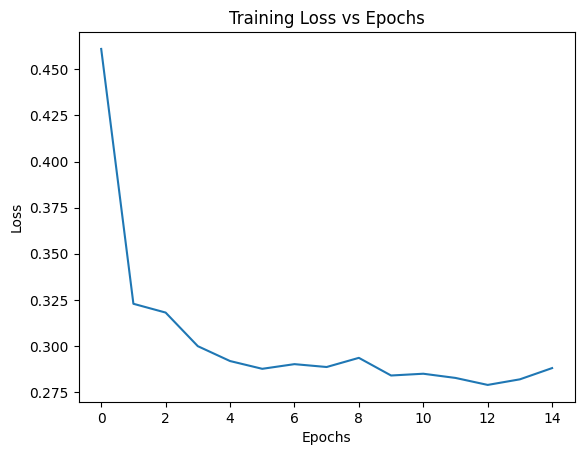

In [ ]:
# Using pytorch to mimic the best performing neural network in the previous
# part. For relu activation function

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Hyperparameters
input_size = 784  # 28x28
h1_size = 500
h2_size = 250
h3_size = 100
output_size = 10
batch_size = 64
learning_rate = 0.01
epochs = 15
alpha = 0.001  # Regularization parameter (L2)

# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Neural Network Definition (with ReLU)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size)
        self.fc2 = nn.Linear(h1_size, h2_size)
        self.fc3 = nn.Linear(h2_size, h3_size)
        self.fc4 = nn.Linear(h3_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation here, logits will be passed to CrossEntropyLoss
        return x

# Instantiate the model
model = NeuralNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)  # Adam optimizer with L2 regularization

# Training Function
def train_model(model, train_loader):
    model.train()
    all_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # Flatten the image data
            data = data.view(-1, input_size)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Loss calculation
            loss = criterion(output, target)
            epoch_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

        # Average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        all_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return all_losses

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, input_size)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(target.numpy())

    accuracy = correct / total * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))

    # Plotting Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[i for i in range(10)], yticklabels=[i for i in range(10)])
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Train the model
train_losses = train_model(model, train_loader)

# Evaluate the model
evaluate_model(model, test_loader)

# Plot the training loss
plt.plot(train_losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


With package, I got low test accuracy for relu activation


In [ ]:
# Neural Network Class with ReLU and L2 Regularization
class NeuralNetwork_r:
    def __init__(self):
        # Weights Initialization
        self.W1 = glorot_init(input_size, h1_size)
        self.b1 = np.zeros((1, h1_size))
        self.W2 = glorot_init(h1_size, h2_size)
        self.b2 = np.zeros((1, h2_size))
        self.W3 = glorot_init(h2_size, h3_size)
        self.b3 = np.zeros((1, h3_size))
        self.W4 = glorot_init(h3_size, output_size)
        self.b4 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, x):
        # Forward Pass
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.output = self.softmax(self.z4)

        return self.output

    def backward(self, x, y, output):
        m = y.shape[0]

        # Output Layer Gradients
        dz4 = output - y
        dW4 = np.dot(self.a3.T, dz4) / m + (alpha/m) * self.W4  # L2 regularization term
        db4 = np.sum(dz4, axis=0, keepdims=True) / m

        # Hidden Layer 3 Gradients
        dz3 = np.dot(dz4, self.W4.T) * (self.a3 > 0)
        dW3 = np.dot(self.a2.T, dz3) / m + (alpha/m) * self.W3  # L2 regularization term
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # Hidden Layer 2 Gradients
        dz2 = np.dot(dz3, self.W3.T) * (self.a2 > 0)
        dW2 = np.dot(self.a1.T, dz2) / m + (alpha/m) * self.W2  # L2 regularization term
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden Layer 1 Gradients
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 > 0)
        dW1 = np.dot(x.T, dz1) / m + (alpha/m) * self.W1  # L2 regularization term
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W4 -= learning_rate * dW4
        self.b4 -= learning_rate * db4
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, train_loader):
        all_losses = []
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                # Flatten the input image (28x28) to a 1D vector of size 784
                x = data.view(-1, input_size).numpy()

                # Convert target labels to one-hot encoding
                y = one_hot_numpy(target.numpy(), num_classes=output_size)

                # Forward pass
                output = self.forward(x)

                # Backward pass
                self.backward(x, y, output)

                # Log the loss every 200 iterations
                if batch_idx % 200 == 0:
                    loss = -np.sum(y * np.log(output + 1e-8)) / y.shape[0]  # Cross entropy loss
                    l2_loss = alpha / (2 * y.shape[0]) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)) + np.sum(np.square(self.W3)) + np.sum(np.square(self.W4)))
                    total_loss = loss + l2_loss
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {total_loss:.4f}')
                    all_losses.append(total_loss)

        return all_losses

    def evaluate(self, data_loader, typ):
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        for data, target in data_loader:
            x = data.view(-1, input_size).numpy()
            target = target.numpy()
            output = self.forward(x)
            preds = np.argmax(output, axis=1)
            all_preds.extend(preds)
            all_labels.extend(target)
            correct += np.sum(preds == target)
            total += target.shape[0]

        accuracy = correct / total
        print(f'{typ} Accuracy: {accuracy * 100:.2f}%')

        cm = confusion_matrix(all_labels, all_preds)
        print(classification_report(all_labels, all_preds))

        # Plotting Confusion Matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[i for i in range(10)], yticklabels=[i for i in range(10)])
        plt.title(f'{typ} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()



In [ ]:
# Instantiate and train the model
model = NeuralNetwork_r()

In [ ]:
train_losses_regul = model.train(train_loader)

Epoch 1/15, Batch 0/938, Loss: 2.7595
Epoch 1/15, Batch 200/938, Loss: 0.6799
Epoch 1/15, Batch 400/938, Loss: 0.3502
Epoch 1/15, Batch 600/938, Loss: 0.2486
Epoch 1/15, Batch 800/938, Loss: 0.4014
Epoch 2/15, Batch 0/938, Loss: 0.3955
Epoch 2/15, Batch 200/938, Loss: 0.2346
Epoch 2/15, Batch 400/938, Loss: 0.3410
Epoch 2/15, Batch 600/938, Loss: 0.1761
Epoch 2/15, Batch 800/938, Loss: 0.1851
Epoch 3/15, Batch 0/938, Loss: 0.2512
Epoch 3/15, Batch 200/938, Loss: 0.1226
Epoch 3/15, Batch 400/938, Loss: 0.3030
Epoch 3/15, Batch 600/938, Loss: 0.2515
Epoch 3/15, Batch 800/938, Loss: 0.0671
Epoch 4/15, Batch 0/938, Loss: 0.1385
Epoch 4/15, Batch 200/938, Loss: 0.1220
Epoch 4/15, Batch 400/938, Loss: 0.1532
Epoch 4/15, Batch 600/938, Loss: 0.1539
Epoch 4/15, Batch 800/938, Loss: 0.1844
Epoch 5/15, Batch 0/938, Loss: 0.1656
Epoch 5/15, Batch 200/938, Loss: 0.1396
Epoch 5/15, Batch 400/938, Loss: 0.2731
Epoch 5/15, Batch 600/938, Loss: 0.0814
Epoch 5/15, Batch 800/938, Loss: 0.2458
Epoch 6/15

Test Accuracy: 97.22%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.99      0.96      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.92      0.98      0.95       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



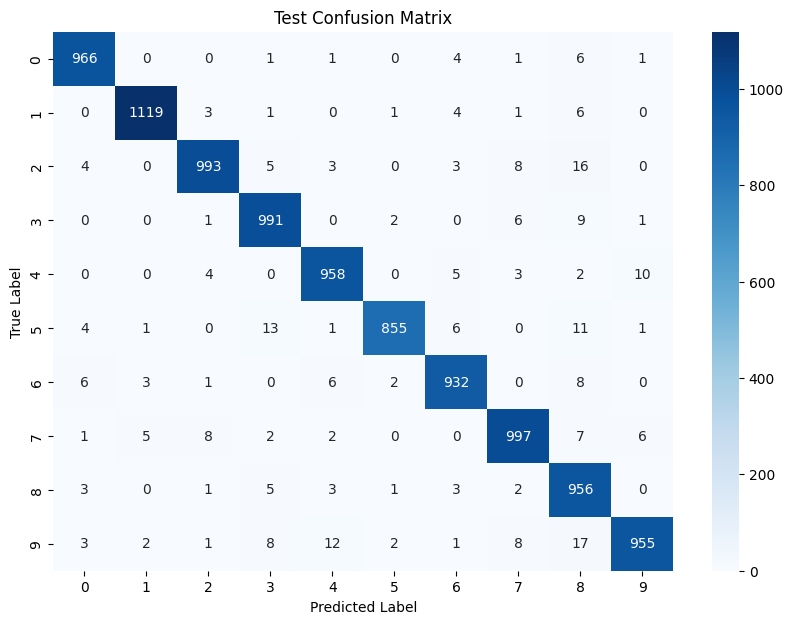

In [ ]:
# Evaluate on test data
model.evaluate(test_loader, typ='Test')

After adding the L2 regularization term, the test accuracy for relu activation model  is increased and loss is also decreased